# Setup

In [12]:
import numpy as np
import torch
import torch.autograd as autograd

# For the Gaussian process regression
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

# For the optimization
import cyipopt
from cyipopt import Problem

# For the NTR
from scipy.spatial import ConvexHull

# For finding minimal disance to the NTR
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

# For hermite quadrature
import itertools
from itertools import product, combinations
from numpy.polynomial.hermite import hermgauss
from scipy.special import roots_hermite as hermgauss

# for QMC (quasi-Monte Carlo)
from torch.quasirandom import SobolEngine
import chaospy as cp

# Plotting
import matplotlib as mpl
from cycler import cycler
from matplotlib import pyplot as plt
import matplotx
from mpl_toolkits.mplot3d import Axes3D
import scienceplots

import logging
from joblib import Parallel, delayed
import os

import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Set up logging configuration
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

import random
random_seed = 20011210
random_seed = 10122001
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


## Designing a custom plotting style and updating scienceplots

In [13]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#cc2300','#094a84', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#cc2300','#094a84', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    # mpl.rcParams['grid.color'] = '#ffffff'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Number of points
# n_points = 100

# # Random Sampling
# random_points = np.random.rand(n_points, 2)

# # Plot for Random Sampling
# plt.figure(figsize=(6, 6))
# plt.scatter(random_points[:, 0], random_points[:, 1], color="blue", s=10)
# plt.title("Random Sampling")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# from scipy.stats.qmc import Halton
# import matplotlib.pyplot as plt

# # Number of points
# n_points = 100

# # Halton Sampling
# halton_sampler = Halton(d=2, scramble=True)
# halton_points = halton_sampler.random(n=n_points)

# # Plot for Halton Sampling
# plt.figure(figsize=(6, 6))
# plt.scatter(halton_points[:, 0], halton_points[:, 1], color="green", s=10)
# plt.title("Halton Sampling")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# from scipy.stats.qmc import Sobol
# import matplotlib.pyplot as plt

# # Number of points
# n_points = 100

# # Sobol Sampling
# sobol_sampler = Sobol(d=2, scramble=True)
# sobol_points = sobol_sampler.random(n=n_points)

# # Plot for Sobol Sampling
# plt.figure(figsize=(6, 6))
# plt.scatter(sobol_points[:, 0], sobol_points[:, 1], color="red", s=10)
# plt.title("Sobol Sampling")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

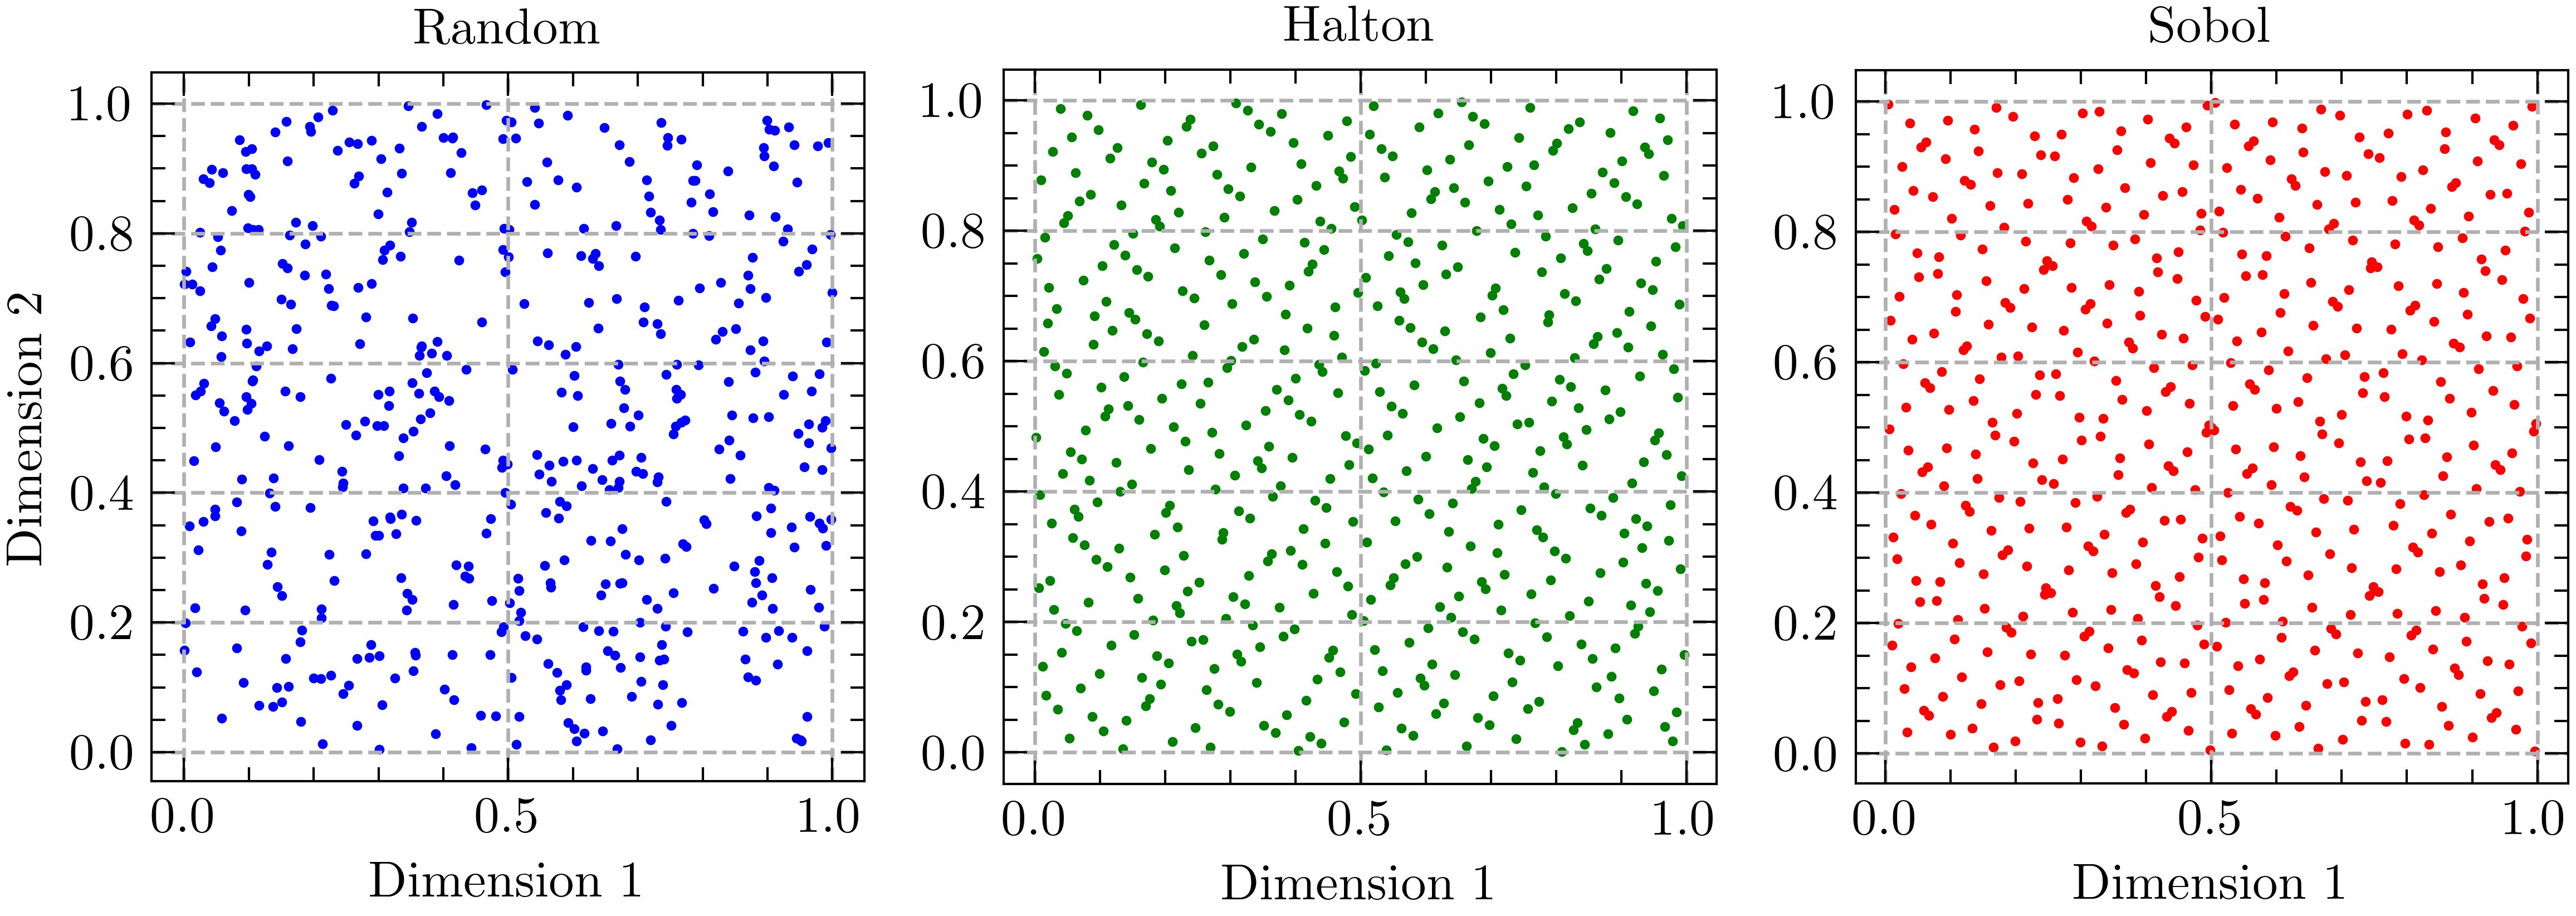

In [18]:
import os
import chaospy
import matplotlib.pyplot as plt

def plot_draws(n=20, d=2, transform=None, print_out=False, 
               rules=["random", "halton", "sobol"], dims=(1,2), figure_name="sampling_plot"):
    # Define the output folder and ensure it exists
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)
    
    # Create the figure and axes
    fig, ax = plt.subplots(1, len(rules), figsize=(8, 3), dpi=600)
    
    # Loop through each sampling rule
    colors = ["b", "g", "r"]  # Define colors for each rule
    for idx, rule in enumerate(rules):       
        d = max(max(dims), d)        
        distribution = chaospy.Iid(chaospy.Uniform(0, 1), d)
        order = n
        x = chaospy.generate_samples(n, domain=d, rule=rule)  # Generate samples (d x N)
        w = 1 / x.shape[1]
        
        # Apply the transform if provided
        if transform:
            x = transform(x)
        
        # Scatter plot for each rule
        ax[idx].scatter(x[dims[0] - 1, :], x[dims[1] - 1, :], marker=".", color=colors[idx], s=5)
        
        # Set labels and titles for each subplot
        ax[idx].set_xlabel("Dimension " + str(dims[0]))
        if idx == 0:  # Only add y-label on the first subplot
            ax[idx].set_ylabel("Dimension " + str(dims[1]))
        ax[idx].set_aspect("equal")
        ax[idx].title.set_text(rule.capitalize())  # Convert rule name to capitalized
        # ax[idx].title.set_text(rule)
        
        # Print output if requested
        if print_out: 
            print(f'dim(x)={d:3d}, order={order:5d}, N={x.shape[1]:5d}, rule={rule}')

    # Save the figure
    output_path = os.path.join(output_folder, f"{figure_name}.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()

# Example usage:
plot_draws(n=500, figure_name="sampling_comparison_d1_d2")

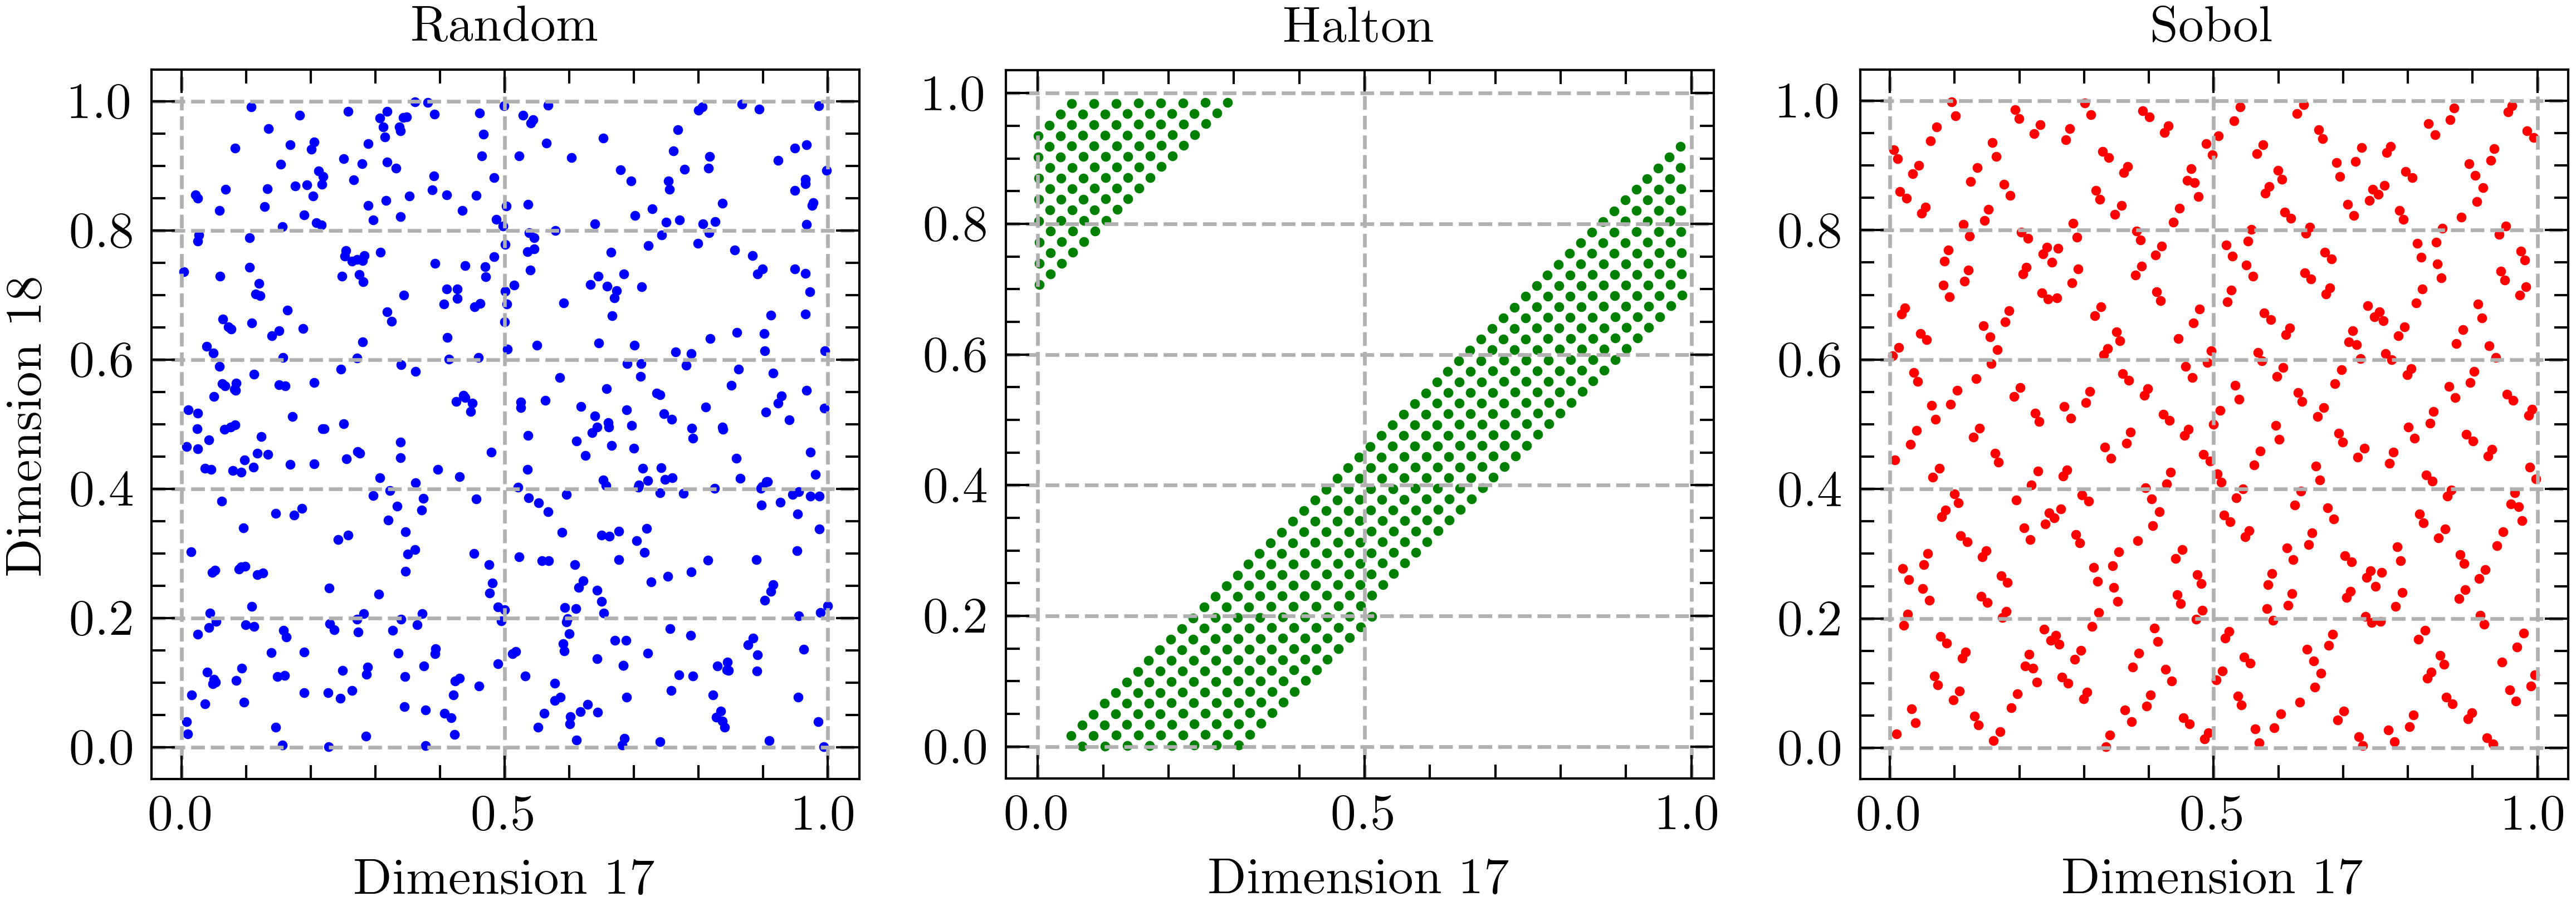

In [19]:
d=18 # try 2, 21, 100 and 200
n=500;
# plot_draws(n, d, dims=(d-1,d), rules=["random", "halton", "sobol"])
# Example usage:
plot_draws(n, d, dims=(d-1,d), rules=["random", "halton", "sobol"], figure_name="sampling_comparison_d17_d18")
